In [2]:
"""
Stock Recommendation System
---------------------------
Purpose: Builds a hybrid recommender combining fundamental analysis (P/E, ROE, Dividend Yield)
with LSTM-based price forecasting to recommend 'Buy' or 'Hold' for stocks. A 5-day moving average
baseline validates LSTM performance.
Structure:
1. Fetch and preprocess fundamental and price data.
2. Compute composite score using PCA-weighted fundamentals.
3. Train LSTM models with technical indicators (MA5, RSI, MACD).
4. Combine signals for recommendations, backtest portfolio, and evaluate.
"""

import os
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

# Seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Defines tickers and date range
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'NVDA', 'TSLA',
           'JPM', 'PLTR', 'CRSP', 'DDOG', 'NKE', 'KO', 'DIS', 'BABA', 'SPY', 'QQQ',
           'LLY', 'CRWD', 'ARM', 'HIMS', 'S', 'SHOP', 'SNOW', 'PANW','LMT',
           'NDAQ', 'WFC', 'GS']
start_date = "2015-01-01"
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')


--- Exploratory Data Analysis (EDA) for Fundamental Data ---

Summary Statistics for Fundamental Data:
       TrailingPE   ForwardPE        ROE  DividendYield
count   29.000000   29.000000  29.000000      29.000000
mean    57.332925   39.733840   0.265724       0.866207
std     89.185428   42.104820   0.369806       1.042560
min     11.230506    0.100000  -0.314550       0.000000
25%     20.534498   16.481026   0.102740       0.000000
50%     29.581299   23.521847   0.173520       0.510000
75%     48.754720   44.129730   0.329080       1.330000
max    477.894740  193.191500   1.365200       2.870000

Correlation Matrix for Fundamental Features:
               TrailingPE  ForwardPE       ROE  DividendYield
TrailingPE       1.000000   0.708978 -0.103561      -0.343327
ForwardPE        0.708978   1.000000 -0.308051      -0.448820
ROE             -0.103561  -0.308051  1.000000       0.123571
DividendYield   -0.343327  -0.448820  0.123571       1.000000


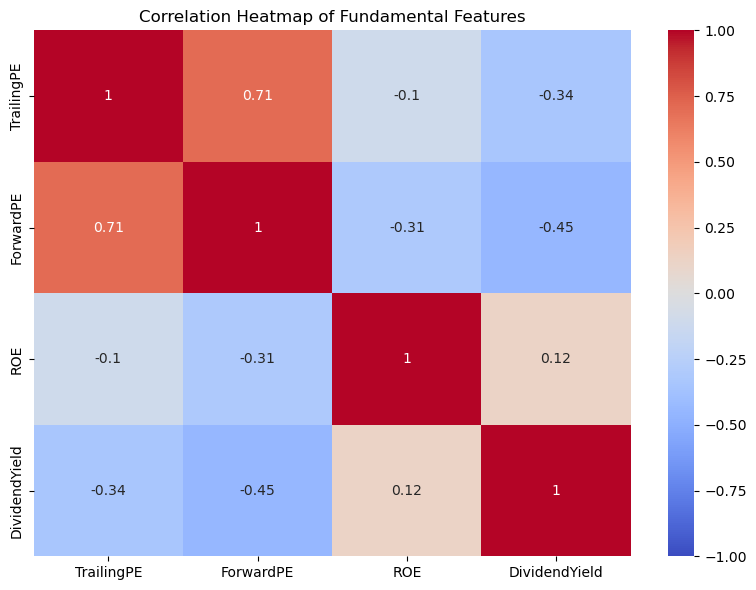

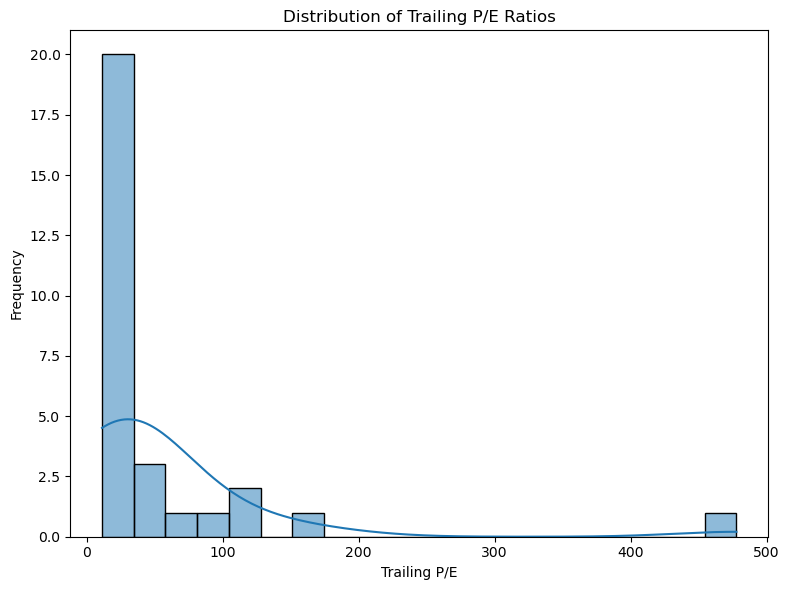

PCA Loadings: [ 0.56714374  0.62497012 -0.27750297 -0.4590778 ]
PCA Explained Variance: 0.5274617379922172
Fundamental Data with Composite Score:
   Ticker  TrailingPE   ForwardPE      ROE  DividendYield  CompositeScore  \
25    LMT   20.534498   16.304873  0.81045           2.84        1.172921   
0    AAPL   30.660316   23.244284  1.36520           0.51        1.079495   
5    NVDA   32.962585   23.521847  1.19177           0.04        0.832032   
11    NKE   18.644518   17.374613  0.31934           2.87        0.774189   
12     KO   29.581299   24.501682  0.39549           2.79        0.719840   
7     JPM   11.230506   13.679212  0.17352           2.41        0.624631   
27    WFC   11.512590   11.659382  0.11021           2.47        0.597435   
28     GS   11.632483   12.063522  0.12255           2.36        0.582670   
14   BABA   16.318520   11.160081  0.10274           1.84        0.449957   
17    LLY   70.035960   36.099735  0.84264           0.71        0.414173   
3   GOO

In [3]:
# Fundamental data
records = []
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        records.append({
            'Ticker': ticker,
            'TrailingPE': info.get('trailingPE'),
            'ForwardPE': info.get('forwardPE'),
            'DividendYield': info.get('dividendYield', 0),
            'ROE': info.get('returnOnEquity')
        })
    except Exception as e:
        print(f"Error fetching fundamental data for {ticker}: {e}")
df_fundamentals = pd.DataFrame(records)

# Cleans data
df_fundamentals_clean = df_fundamentals.copy()
for col in ['TrailingPE', 'ForwardPE', 'ROE']:
    df_fundamentals_clean[col] = df_fundamentals_clean[col].fillna(df_fundamentals_clean[col].median())
df_fundamentals_clean['ForwardPE'] = df_fundamentals_clean['ForwardPE'].apply(lambda x: max(x, 0.1))

# --- Exploratory Data Analysis for Fundamental Data ---
print("\n--- Exploratory Data Analysis (EDA) for Fundamental Data ---")

# Summary stats for fundamental data
print("\nSummary Statistics for Fundamental Data:")
print(df_fundamentals_clean[['TrailingPE', 'ForwardPE', 'ROE', 'DividendYield']].describe())

# Correlation analysis for fundamental features
print("\nCorrelation Matrix for Fundamental Features:")
correlation_matrix = df_fundamentals_clean[['TrailingPE', 'ForwardPE', 'ROE', 'DividendYield']].corr()
print(correlation_matrix)

# Correlation matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlation Heatmap of Fundamental Features")
plt.tight_layout()
plt.show()

# Visualizes distribution of TrailingPE to identify outliers or skewness
plt.figure(figsize=(8, 6))
sns.histplot(df_fundamentals_clean['TrailingPE'], bins=20, kde=True)
plt.title("Distribution of Trailing P/E Ratios")
plt.xlabel("Trailing P/E")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Scales features
features = df_fundamentals_clean[['TrailingPE', 'ForwardPE', 'ROE', 'DividendYield']]
scaler_fund = StandardScaler()
scaled_features = scaler_fund.fit_transform(features)
df_scaled = pd.DataFrame(scaled_features,
                         columns=['TrailingPE_scaled', 'ForwardPE_scaled', 'ROE_scaled', 'DividendYield_scaled'],
                         index=df_fundamentals_clean.index)

# PCA
pca = PCA(n_components=1)
df_fundamentals_clean['PCAScore'] = pca.fit_transform(scaled_features)
print("PCA Loadings:", pca.components_[0])
print("PCA Explained Variance:", pca.explained_variance_ratio_[0])

# Computes composite score (PCA-guided weights)
df_fundamentals_clean['CompositeScore'] = (
    -0.4 * df_scaled['TrailingPE_scaled'] +
    -0.3 * df_scaled['ForwardPE_scaled'] +
     0.3 * df_scaled['ROE_scaled'] +
     0.2 * df_scaled['DividendYield_scaled']
)
df_fundamentals_clean = pd.concat([df_fundamentals_clean, df_scaled], axis=1)
df_fundamentals_clean = df_fundamentals_clean.sort_values('CompositeScore', ascending=False)

print("Fundamental Data with Composite Score:")
print(df_fundamentals_clean[['Ticker', 'TrailingPE', 'ForwardPE', 'ROE', 'DividendYield', 'CompositeScore', 'PCAScore']])

[                       0%                       ]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  29 of 29 completed



--- Exploratory Data Analysis (EDA) for Price Data ---

Summary Statistics for Closing Prices:
              AAPL         MSFT         AMZN        GOOGL         META  \
count  2590.000000  2590.000000  2590.000000  2590.000000  2590.000000   
mean     97.922569   187.911886   104.339483    85.011546   232.790874   
std      68.363052   127.257436    56.490695    45.768914   137.511662   
min      20.674534    34.621780    14.347500    24.734745    73.702637   
25%      35.888573    66.606607    48.946875    47.628041   137.977219   
50%      70.146374   157.742920    95.465500    67.059395   184.306366   
75%     156.645252   284.552086   156.869873   123.161175   293.611214   
max     258.735504   464.854340   242.059998   206.142593   736.015198   

              NVDA         TSLA          JPM         PLTR         CRSP  ...  \
count  2590.000000  2590.000000  2590.000000  1144.000000  2137.000000  ...   
mean     23.697569   121.448687   109.315533    24.442649    58.539642  ...   


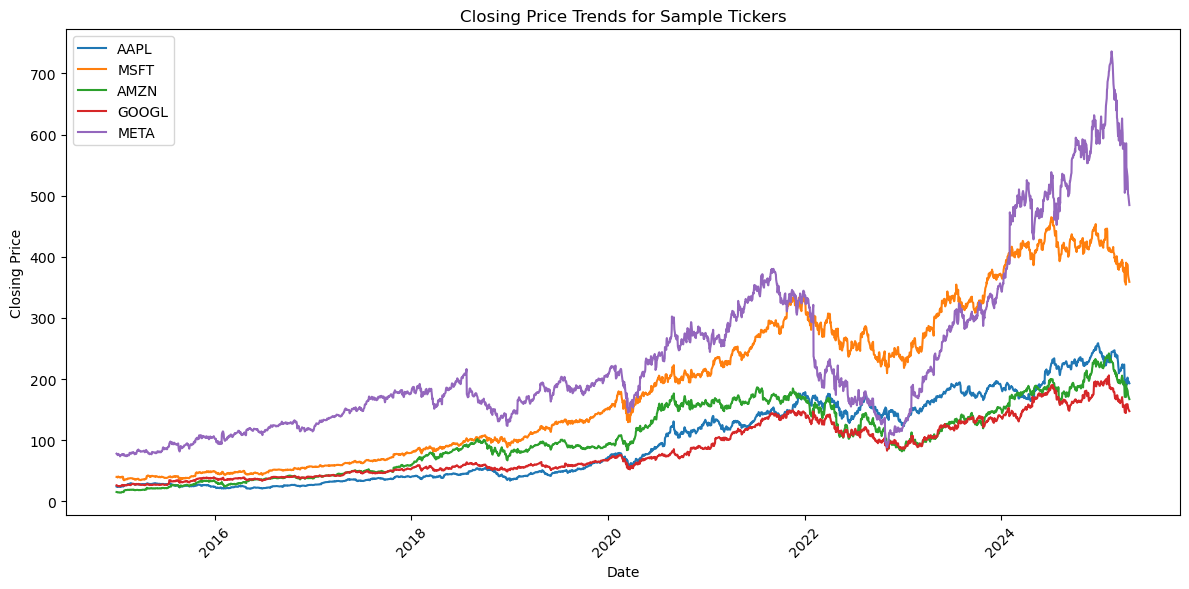

Processed data for AAPL
Processed data for MSFT
Processed data for AMZN
Processed data for GOOGL
Processed data for META
Processed data for NVDA
Processed data for TSLA
Processed data for JPM
Processed data for PLTR
Processed data for CRSP
Processed data for DDOG
Processed data for NKE
Processed data for KO
Processed data for DIS
Processed data for BABA
Processed data for SPY
Processed data for QQQ
Processed data for LLY
Processed data for CRWD
Processed data for ARM
Processed data for HIMS
Processed data for S
Processed data for SHOP
Processed data for SNOW
Processed data for PANW
Processed data for LMT
Processed data for NDAQ
Processed data for WFC
Processed data for GS


In [4]:
# Downloads price data
price_data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')

# --- Exploratory Data Analysis for Price Data ---
print("\n--- Exploratory Data Analysis (EDA) for Price Data ---")

# Summary stats for closing prices (all tickers)
close_prices = pd.concat([price_data.xs(ticker, level=0, axis=1)['Close'] for ticker in tickers], axis=1)
close_prices.columns = tickers
print("\nSummary Statistics for Closing Prices:")
print(close_prices.describe())

# Visualizes closing price trends, first 5 tickers)
sample_tickers = tickers[:5]  # first 5 tickers for visualization
plt.figure(figsize=(12, 6))
for ticker in sample_tickers:
    plt.plot(close_prices.index, close_prices[ticker], label=ticker)
plt.title("Closing Price Trends for Sample Tickers")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Defines sequence length
seq_length = 5

# Initializes dictionaries
X_dict, y_dict = {}, {}
processed_data = {}
scalers = {}

# Creates sequences
def create_sequences(data_array, seq_length):
    X, y = [], []
    for i in range(len(data_array) - seq_length):
        X.append(data_array[i:i + seq_length])
        y.append(data_array[i + seq_length, 0])  # Predict 'Close'
    return np.array(X), np.array(y)

# Price data
for ticker in tickers:
    try:
        df_price = price_data.xs(ticker, level=0, axis=1)
        if df_price.empty or df_price['Close'].isna().all():
            print(f"No data available for {ticker}")
            continue
        df_price = df_price[['Close', 'Volume']].dropna().copy()
        if df_price.empty:
            print(f"No valid data for {ticker} after dropping NaNs")
            continue
        
        # Technical indicators using pandas_ta
        df_price['MA5'] = df_price['Close'].rolling(window=5).mean().bfill()
        df_price['RSI'] = ta.rsi(df_price['Close'], length=14)
        df_price['MACD'] = ta.macd(df_price['Close'], fast=12, slow=26, signal=9)['MACD_12_26_9']
        df_price = df_price.dropna()
        
        if len(df_price) < seq_length:
            print(f"Not enough data for {ticker}")
            continue
        
        # Scales features
        scaler_price = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler_price.fit_transform(df_price[['Close', 'Volume', 'MA5', 'RSI', 'MACD']])
        scalers[ticker] = scaler_price
        processed_data[ticker] = pd.DataFrame(scaled_data,
                                             columns=['Close_scaled', 'Volume_scaled', 'MA5_scaled', 'RSI_scaled', 'MACD_scaled'],
                                             index=df_price.index)
        
        # Creates sequences
        X_seq, y_seq = create_sequences(scaled_data, seq_length)
        X_seq = X_seq.reshape(X_seq.shape[0], seq_length, scaled_data.shape[1])
        X_dict[ticker], y_dict[ticker] = X_seq, y_seq
        print(f"Processed data for {ticker}")
    except KeyError:
        print(f"No data available for {ticker}")
    except Exception as e:
        print(f"Error processing price data for {ticker}: {e}")

In [5]:
baseline_preds = {}
rmse_baseline = {}

# Computes baseline (5-day MA)
for ticker in tickers:
    try:
        close_prices = price_data.xs(ticker, level=0, axis=1)['Close'].dropna()
        baseline = close_prices.rolling(window=5).mean().shift(1).iloc[seq_length:]
        if ticker not in y_dict:
            print(f"No sequences for {ticker}")
            continue
        y_all_pad = np.concatenate([y_dict[ticker].reshape(-1, 1), np.zeros((len(y_dict[ticker]), 4))], axis=1)
        actual_prices = scalers[ticker].inverse_transform(y_all_pad)[:, 0]
        baseline_preds[ticker] = baseline.values
        rmse_baseline[ticker] = math.sqrt(mean_squared_error(actual_prices, baseline_preds[ticker][:len(actual_prices)]))
        print(f"Baseline {ticker}: RMSE = {rmse_baseline[ticker]:.2f}")
    except Exception as e:
        print(f"Error computing baseline for {ticker}: {e}")

Baseline AAPL: RMSE = 10.59
Baseline MSFT: RMSE = 15.94
Baseline AMZN: RMSE = 11.80
Baseline GOOGL: RMSE = 8.21
Baseline META: RMSE = 31.52
Baseline NVDA: RMSE = 6.67
Baseline TSLA: RMSE = 37.37
Baseline JPM: RMSE = 9.87
Baseline PLTR: RMSE = 7.89
Baseline CRSP: RMSE = 14.37
Baseline DDOG: RMSE = 17.38
Baseline NKE: RMSE = 8.88
Baseline KO: RMSE = 2.61
Baseline DIS: RMSE = 10.80
Baseline BABA: RMSE = 16.96
Baseline SPY: RMSE = 17.71
Baseline QQQ: RMSE = 18.00
Baseline LLY: RMSE = 36.23
Baseline CRWD: RMSE = 37.06
Baseline ARM: RMSE = 30.48
Baseline HIMS: RMSE = 4.70
Baseline S: RMSE = 6.32
Baseline SHOP: RMSE = 11.81
Baseline SNOW: RMSE = 35.04
Baseline PANW: RMSE = 9.20
Baseline LMT: RMSE = 24.27
Baseline NDAQ: RMSE = 3.25
Baseline WFC: RMSE = 4.19
Baseline GS: RMSE = 26.55


In [6]:
def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_predictions = {}
lstm_models = {}
rmse_lstm = {}

# Trains LSTM models

for ticker in tickers:
    try:
        if ticker not in X_dict:
            print(f"No data for LSTM training for {ticker}")
            continue
        X_all, y_all = X_dict[ticker], y_dict[ticker]
        split_index = int(len(X_all) * 0.8)
        X_train, X_test = X_all[:split_index], X_all[split_index:]
        y_train, y_test = y_all[:split_index], y_all[split_index:]
        model = build_lstm_model((seq_length, X_train.shape[2]))
        model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)
        pred_scaled = model.predict(X_all, verbose=0)
        pred_pad = np.concatenate([pred_scaled, np.zeros((pred_scaled.shape[0], 4))], axis=1)
        y_all_pad = np.concatenate([y_all.reshape(-1, 1), np.zeros((len(y_all), 4))], axis=1)
        pred_inversed = scalers[ticker].inverse_transform(pred_pad)[:, 0]
        y_inversed = scalers[ticker].inverse_transform(y_all_pad)[:, 0]
        rmse_val = math.sqrt(mean_squared_error(y_inversed, pred_inversed))
        rmse_lstm[ticker] = rmse_val
        lstm_predictions[ticker] = pred_inversed
        lstm_models[ticker] = model
        print(f"{ticker}: LSTM RMSE = {rmse_val:.2f}")
    except Exception as e:
        print(f"Error training LSTM for {ticker}: {e}")

mae_lstm = {}
directional_accuracy = {}

def compute_directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    predicted_diff = np.diff(predicted)
    return np.mean(np.sign(actual_diff) == np.sign(predicted_diff))

for ticker in tickers:
    try:
        if ticker not in lstm_predictions:
            print(f"No predictions for {ticker}")
            continue
        y_all_pad = np.concatenate([y_dict[ticker].reshape(-1, 1), np.zeros((len(y_dict[ticker]), 4))], axis=1)
        actual_prices = scalers[ticker].inverse_transform(y_all_pad)[:, 0]
        mae_val = mean_absolute_error(actual_prices, lstm_predictions[ticker][:len(actual_prices)])
        mae_lstm[ticker] = mae_val
        dir_acc = compute_directional_accuracy(actual_prices, lstm_predictions[ticker][:len(actual_prices)])
        directional_accuracy[ticker] = dir_acc
        print(f"{ticker}: LSTM MAE = {mae_val:.2f}, Directional Accuracy = {dir_acc*100:.2f}%")
    except Exception as e:
        print(f"Error evaluating metrics for {ticker}: {e}")

AAPL: LSTM RMSE = 3.94
MSFT: LSTM RMSE = 11.21
AMZN: LSTM RMSE = 3.90
GOOGL: LSTM RMSE = 3.80
META: LSTM RMSE = 19.33
NVDA: LSTM RMSE = 3.19
TSLA: LSTM RMSE = 10.42
JPM: LSTM RMSE = 3.75
PLTR: LSTM RMSE = 3.81
CRSP: LSTM RMSE = 4.24
DDOG: LSTM RMSE = 5.19
NKE: LSTM RMSE = 2.50
KO: LSTM RMSE = 0.82
DIS: LSTM RMSE = 3.06
BABA: LSTM RMSE = 4.55
SPY: LSTM RMSE = 6.02
QQQ: LSTM RMSE = 9.17
LLY: LSTM RMSE = 11.57
CRWD: LSTM RMSE = 9.82
ARM: LSTM RMSE = 8.80
HIMS: LSTM RMSE = 1.54
S: LSTM RMSE = 2.10
SHOP: LSTM RMSE = 3.34
SNOW: LSTM RMSE = 11.80
PANW: LSTM RMSE = 4.52
LMT: LSTM RMSE = 6.89
NDAQ: LSTM RMSE = 0.98
WFC: LSTM RMSE = 1.44
GS: LSTM RMSE = 8.27
AAPL: LSTM MAE = 2.76, Directional Accuracy = 49.43%
MSFT: LSTM MAE = 6.74, Directional Accuracy = 48.73%
AMZN: LSTM MAE = 2.69, Directional Accuracy = 49.75%
GOOGL: LSTM MAE = 3.04, Directional Accuracy = 48.77%
META: LSTM MAE = 11.01, Directional Accuracy = 50.92%
NVDA: LSTM MAE = 1.30, Directional Accuracy = 50.10%
TSLA: LSTM MAE = 6.01, 


Final Recommendations with Enhanced Metrics:
   Ticker  CompositeScore  PCAScore  LSTM_Score  DirectionalAccuracy  \
4      KO        0.719840 -1.370908    0.817857             0.482220   
0     LMT        1.172921 -1.892582    6.889617             0.499023   
1    AAPL        1.079495 -1.101733    3.939566             0.494334   
3     NKE        0.774189 -1.527045    2.504731             0.502931   
6     WFC        0.597435 -1.320573    1.438076             0.491208   
2    NVDA        0.832032 -0.739573    3.190577             0.500977   
15   NDAQ        0.174274 -0.476615    0.981089             0.493161   
5     JPM        0.624631 -1.313348    3.754653             0.495115   
7      GS        0.582670 -1.273821    8.270841             0.504494   
8    BABA        0.449957 -1.008985    4.546148             0.498242   
10  GOOGL        0.333136 -0.501151    3.801291             0.487691   
9     LLY        0.414173 -0.343267   11.569493             0.499023   
13    SPY        0

[*********************100%***********************]  1 of 1 completed


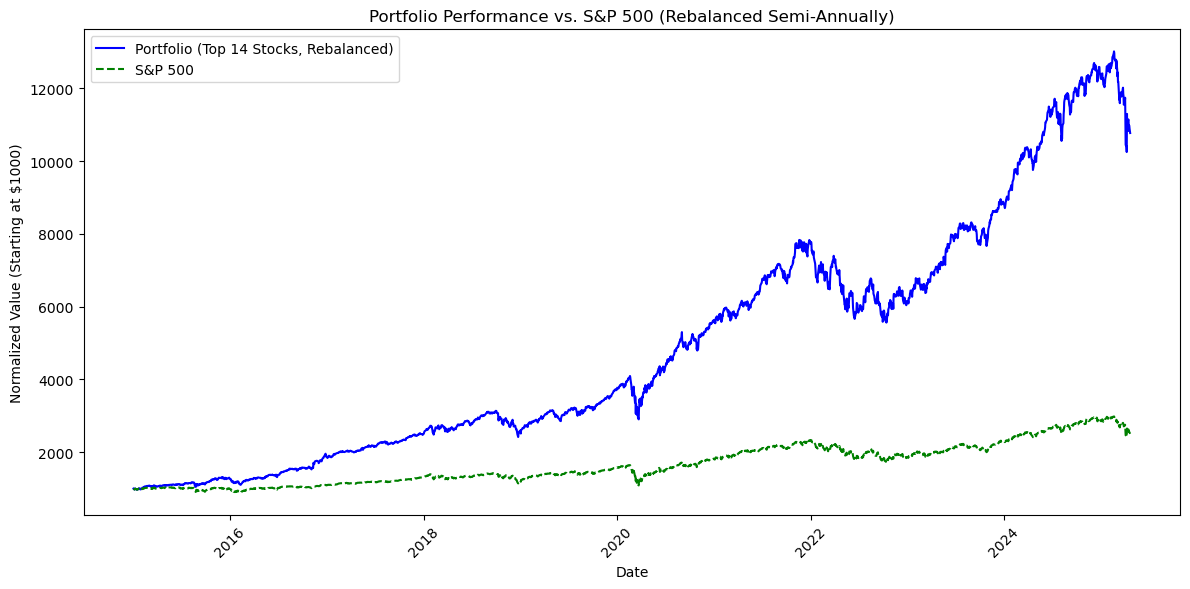


Portfolio Performance Metrics:
Portfolio Annual Return: 25.22%
Portfolio Volatility: 20.35%
Portfolio Sharpe Ratio: 1.09
S&P 500 Annual Return: 10.61%
S&P 500 Volatility: 18.23%
S&P 500 Sharpe Ratio: 0.42


/var/folders/4f/msch0s6j1yl3hy5hm9g9nv4r0000gn/T/ipykernel_76293/525771918.py:190: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  portfolio_returns = portfolio_rebalanced['Portfolio_Total'].pct_change().dropna()


In [7]:
# Computes volatility for risk adjustment
volatility = {}
for ticker in tickers:
    try:
        close_prices = price_data.xs(ticker, level=0, axis=1)['Close'].dropna()
        returns = close_prices.pct_change().dropna()
        volatility[ticker] = returns.std() * np.sqrt(252)  # Annualized volatility
    except Exception as e:
        volatility[ticker] = np.nan
        print(f"Error computing volatility for {ticker}: {e}")

sector_mapping = {
    'AAPL': 'Technology', 'MSFT': 'Technology', 'AMZN': 'Consumer Cyclical', 'GOOGL': 'Technology',
    'META': 'Technology', 'NVDA': 'Technology', 'TSLA': 'Consumer Cyclical', 'JPM': 'Financial Services',
    'PLTR': 'Technology', 'CRSP': 'Healthcare', 'DDOG': 'Technology', 'NKE': 'Consumer Cyclical',
    'KO': 'Consumer Defensive', 'DIS': 'Communication Services', 'BABA': 'Consumer Cyclical',
    'SPY': 'Index', 'QQQ': 'Index', 'LLY': 'Healthcare', 'CRWD': 'Technology', 'ARM': 'Technology',
    'HIMS': 'Healthcare', 'S': 'Technology', 'SHOP': 'Technology', 'SNOW': 'Technology',
    'PANW': 'Technology', 'LMT': 'Industrials', 'WFC': 'Financial Services',
    'NDAQ': 'Financial Services',
    'GS': 'Financial Services'
}

# Combines signals
df_final = df_fundamentals_clean[['Ticker', 'CompositeScore', 'PCAScore']].merge(
    pd.Series(rmse_lstm, name='LSTM_Score').reset_index(),
    left_on='Ticker', right_on='index'
).merge(
    pd.Series(directional_accuracy, name='DirectionalAccuracy').reset_index(),
    left_on='Ticker', right_on='index'
).merge(
    pd.Series(volatility, name='Volatility').reset_index(),
    left_on='Ticker', right_on='index'
)

# Normalizes volatility (scale between 0 and 1)
vol_scaler = MinMaxScaler()
df_final['Volatility_Scaled'] = vol_scaler.fit_transform(df_final[['Volatility']])

# Enhanced CombinedScore: Includes directional accuracy and penalizes volatility
df_final['CombinedScore'] = (
    0.5 * df_final['CompositeScore'] +  # Fundamental score
    0.3 * (1 / df_final['LSTM_Score']) +  # Predictive accuracy (inverse RMSE)
    0.2 * df_final['DirectionalAccuracy'] -  # Directional accuracy
    0.1 * df_final['Volatility_Scaled']  # Risk penalty
)

# Alternative: PCA-based score for comparison
df_final['PCA_CombinedScore'] = (
    0.5 * df_final['PCAScore'] +
    0.3 * (1 / df_final['LSTM_Score']) +
    0.2 * df_final['DirectionalAccuracy'] -
    0.1 * df_final['Volatility_Scaled']
)

# Adds sector to df_final
df_final['Sector'] = df_final['Ticker'].map(sector_mapping)

# Computes annualized returns for Sharpe Ratio
returns_dict = {}
for ticker in tickers:
    try:
        close_prices = price_data.xs(ticker, level=0, axis=1)['Close'].dropna()
        returns = close_prices.pct_change().dropna()
        returns_dict[ticker] = returns.mean() * 252  # Annualized return
    except Exception as e:
        returns_dict[ticker] = np.nan
        print(f"Error computing returns for {ticker}: {e}")

df_final['AnnualizedReturn'] = df_final['Ticker'].map(returns_dict)

# Computes Sharpe Ratio (assuming risk-free rate = 0)
df_final['SharpeRatio'] = df_final['AnnualizedReturn'] / df_final['Volatility']

# Sorts by CombinedScore
df_final = df_final.sort_values('CombinedScore', ascending=False)

# Dynamic threshold: Uses the median CombinedScore
BUY_THRESHOLD = df_final['CombinedScore'].median()
df_final['Recommendation'] = np.where(
    df_final['CombinedScore'] > BUY_THRESHOLD, 'Buy', 'Hold'
)

# Last prices
last_prices = {}
for ticker in tickers:
    try:
        last_prices[ticker] = price_data.xs(ticker, level=0, axis=1)['Close'].iloc[-1]
    except Exception:
        last_prices[ticker] = np.nan

df_final['LastPrice'] = df_final['Ticker'].apply(lambda t: last_prices.get(t, np.nan))
df_final['PredictedPrice'] = df_final['Ticker'].apply(lambda t: lstm_predictions.get(t, [np.nan])[-1])

# Prints final recommendations
print("\nFinal Recommendations with Enhanced Metrics:")
print(df_final[['Ticker', 'CompositeScore', 'PCAScore', 'LSTM_Score', 'DirectionalAccuracy', 'Volatility', 'CombinedScore', 'PCA_CombinedScore', 'Recommendation', 'LastPrice', 'PredictedPrice']])

# Selects top stocks with sector diversification (with updated sector limits)
volatile_sectors = ['Technology', 'Consumer Cyclical', 'Healthcare']
sector_limits = {sector: 2 if sector in volatile_sectors or sector == 'Financial Services' else 3 for sector in sector_mapping.values()}

TOP_N = 14
selected_tickers = []
sector_counts = {}

# Sorts by combination of CombinedScore and SharpeRatio (increased Sharpe weight)
df_final['SelectionScore'] = 0.5 * df_final['CombinedScore'] + 0.5 * df_final['SharpeRatio']

# Filters out high-volatility stocks, based on threshold
volatility_threshold = 0.5
df_final_filtered = df_final[df_final['Volatility'] <= volatility_threshold]

for _, row in df_final_filtered.sort_values('SelectionScore', ascending=False).iterrows():
    ticker = row['Ticker']
    sector = row['Sector']
    if len(selected_tickers) >= TOP_N:
        break
    if sector not in sector_counts:
        sector_counts[sector] = 0
    if sector_counts[sector] < sector_limits[sector]:
        selected_tickers.append(ticker)
        sector_counts[sector] += 1

print(f"Stock Picks, w Sector Diversification: {selected_tickers}")
print("Sector Distribution:", sector_counts)

# Backtests portfolio with rebalancing

portfolio = pd.concat([price_data.xs(ticker, level=0, axis=1)['Close'] for ticker in selected_tickers], axis=1)
portfolio.columns = selected_tickers

# Portfolio data starts from start_date
portfolio = portfolio.loc[start_date:end_date]

# Rebalances semi-annually
rebalance_dates = pd.date_range(start=start_date, end=end_date, freq='6ME')
portfolio_rebalanced = pd.DataFrame(index=portfolio.index)

# Computes inverse volatility weights -> weighted in inverse proportion to the volatility of their returns
volatilities = df_final[df_final['Ticker'].isin(selected_tickers)][['Ticker', 'Volatility']].set_index('Ticker')
inverse_vol = 1 / volatilities['Volatility']
weights = inverse_vol / inverse_vol.sum()  # Normalize to sum to 1

# Simulates rebalancing with dynamic weights and stop-loss
current_portfolio = pd.DataFrame(index=portfolio.index, columns=selected_tickers)
current_portfolio.iloc[0] = weights * 1000  # Start with $100 normalized value

stop_loss_threshold = 0.9  # 10% loss threshold
for i in range(1, len(portfolio)):
    date = portfolio.index[i]
    prev_date = portfolio.index[i-1]
    
    # Calculates daily returns
    returns = portfolio.loc[prev_date:date].pct_change().iloc[-1]
    current_portfolio.iloc[i] = current_portfolio.iloc[i-1] * (1 + returns)
    
    # Applies stop-loss cap
    current_portfolio.iloc[i] = np.maximum(current_portfolio.iloc[i], current_portfolio.iloc[i-1] * stop_loss_threshold)
    
    # Rebalances semi-annually with dynamic weights
    if date in rebalance_dates:
        total_value = current_portfolio.iloc[i].sum()
        current_portfolio.iloc[i] = weights * total_value

# Total portfolio value
portfolio_rebalanced['Portfolio_Total'] = current_portfolio.sum(axis=1)

# Downloads S&P 500 data for benchmark
sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Close']
sp500 = sp500.reindex(portfolio_rebalanced.index, method='ffill')

# Normalizes both portfolio and S&P 500 to start at 1000
portfolio_rebalanced['Portfolio_Normalized'] = (portfolio_rebalanced['Portfolio_Total'] / portfolio_rebalanced['Portfolio_Total'].iloc[0]) * 1000
sp500_normalized = (sp500 / sp500.iloc[0]) * 1000

# Portfolio performance
plt.figure(figsize=(12, 6))
plt.plot(portfolio_rebalanced.index, portfolio_rebalanced['Portfolio_Normalized'], label='Portfolio (Top 14 Stocks, Rebalanced)', color='blue')
plt.plot(sp500.index, sp500_normalized, label='S&P 500', color='green', linestyle='--')
plt.title('Portfolio Performance vs. S&P 500 (Rebalanced Semi-Annually)')
plt.xlabel("Date")
plt.ylabel("Normalized Value (Starting at $1000)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Portfolio metrics
portfolio_returns = portfolio_rebalanced['Portfolio_Total'].pct_change().dropna()
portfolio_annual_return = portfolio_returns.mean() * 252
portfolio_volatility = portfolio_returns.std() * np.sqrt(252)

sp500_returns = sp500.pct_change().dropna()
sp500_annual_return = sp500_returns.mean() * 252
sp500_volatility = sp500_returns.std() * np.sqrt(252)

# Risk-free rate for Sharpe Ratio
risk_free_rate = 0.03  # 3% annual risk-free rate
portfolio_sharpe = (portfolio_annual_return - risk_free_rate) / portfolio_volatility
sp500_sharpe = (sp500_annual_return - risk_free_rate) / sp500_volatility

# Ensures scalar values for printing
portfolio_annual_return = portfolio_annual_return.item() if isinstance(portfolio_annual_return, pd.Series) else portfolio_annual_return
portfolio_volatility = portfolio_volatility.item() if isinstance(portfolio_volatility, pd.Series) else portfolio_volatility
portfolio_sharpe = portfolio_sharpe.item() if isinstance(portfolio_sharpe, pd.Series) else portfolio_sharpe
sp500_annual_return = sp500_annual_return.item() if isinstance(sp500_annual_return, pd.Series) else sp500_annual_return
sp500_volatility = sp500_volatility.item() if isinstance(sp500_volatility, pd.Series) else sp500_volatility
sp500_sharpe = sp500_sharpe.item() if isinstance(sp500_sharpe, pd.Series) else sp500_sharpe

print("\nPortfolio Performance Metrics:")
print(f"Portfolio Annual Return: {portfolio_annual_return:.2%}")
print(f"Portfolio Volatility: {portfolio_volatility:.2%}")
print(f"Portfolio Sharpe Ratio: {portfolio_sharpe:.2f}")
print(f"S&P 500 Annual Return: {sp500_annual_return:.2%}")
print(f"S&P 500 Volatility: {sp500_volatility:.2%}")
print(f"S&P 500 Sharpe Ratio: {sp500_sharpe:.2f}")

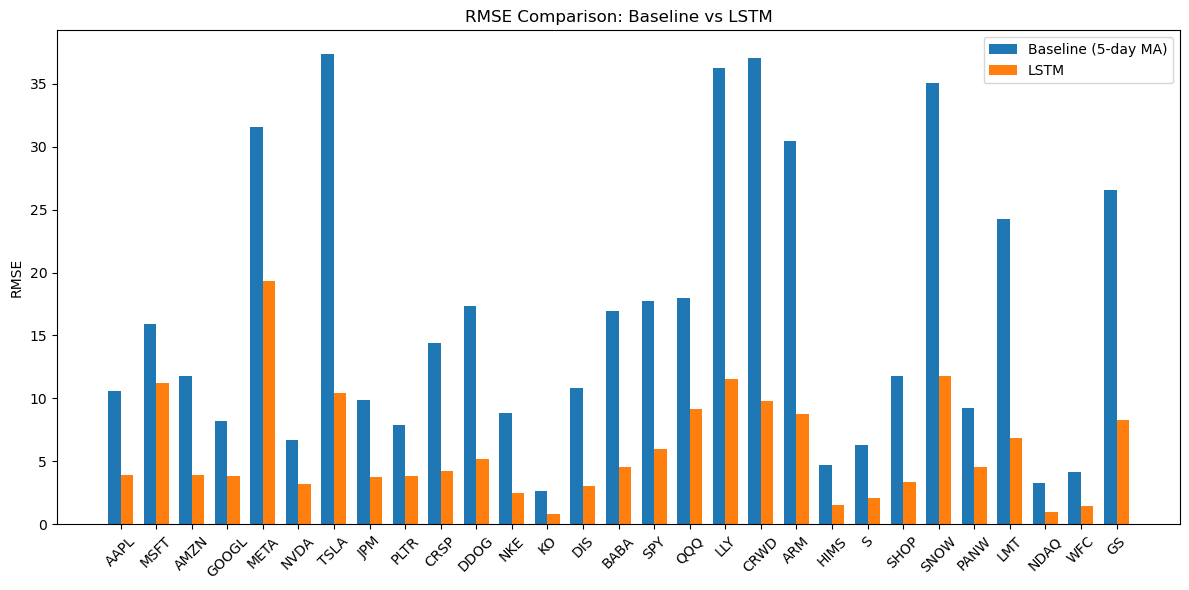

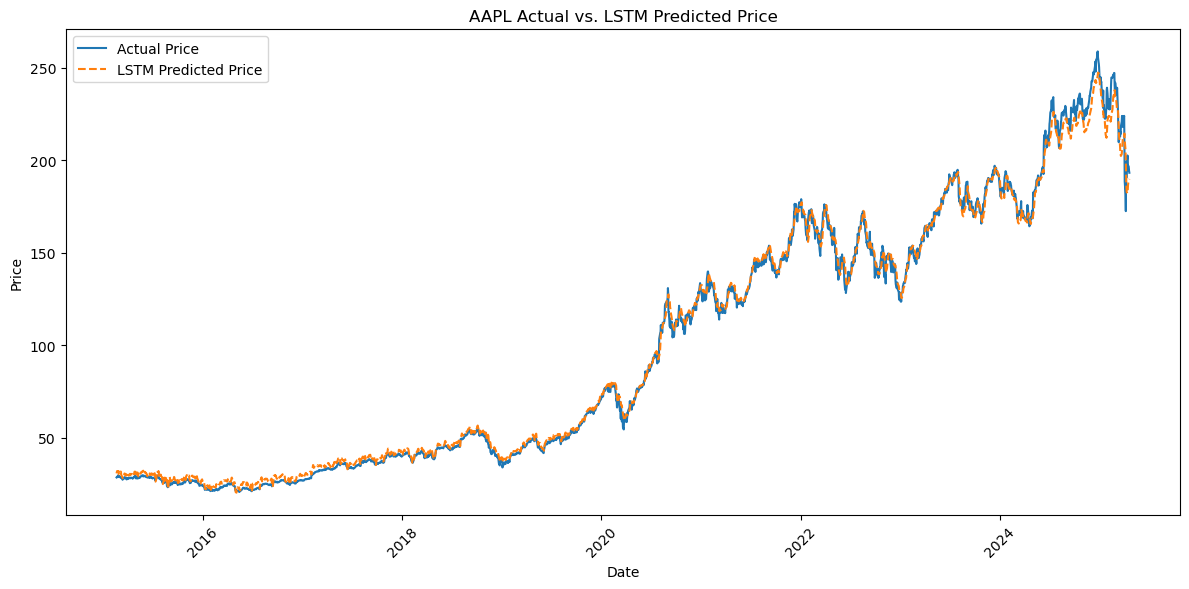

In [8]:
# RMSE comparison plot
tickers_list = list(rmse_baseline.keys())
baseline_rmse = [rmse_baseline.get(t, np.nan) for t in tickers_list]
lstm_rmse = [rmse_lstm.get(t, np.nan) for t in tickers_list]
x = np.arange(len(tickers_list))
width = 0.35
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, baseline_rmse, width, label='Baseline (5-day MA)')
ax.bar(x + width/2, lstm_rmse, width, label='LSTM')
ax.set_ylabel('RMSE')
ax.set_title('RMSE Comparison: Baseline vs LSTM')
ax.set_xticks(x)
ax.set_xticklabels(tickers_list, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

# Actual v Predicted (Apple)
ticker_plot = 'AAPL'
if ticker_plot in processed_data:
    dates = processed_data[ticker_plot].index[seq_length:]
    actual_pad = np.concatenate([y_dict[ticker_plot].reshape(-1, 1), np.zeros((len(y_dict[ticker_plot]), 4))], axis=1)
    actual_inversed = scalers[ticker_plot].inverse_transform(actual_pad)[:, 0]
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual_inversed[:len(dates)], label='Actual Price')
    plt.plot(dates, lstm_predictions[ticker_plot][:len(dates)], label='LSTM Predicted Price', linestyle='--')
    plt.title(f"{ticker_plot} Actual vs. LSTM Predicted Price")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()